# Importing Modules in Python

In [31]:
import numpy as np
import pandas as pd

In [32]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

# Creating variables for train and test data

In [80]:
test_df=pd.read_csv('./valid-edemaonly.csv')
test_df.head()

,Unnamed: 0,Path,Sex,Age,Frontal/Lateral,AP/PA,Edema
0,0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0
1,1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0
2,3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,1.0
3,4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,0.0
4,5,CheXpert-v1.0-small/valid/patient64545/study1/...,Female,55,Frontal,AP,0.0


In [81]:
test_df.drop(labels=['Unnamed: 0','Sex','Age','Frontal/Lateral','AP/PA'], axis=1, inplace=True)

In [82]:
test_df.Edema.replace([-1.0,1.0,0.0], ['uncertain', 'edema','no_edema'], inplace=True)

In [83]:
test_df.head()

,Path,Edema
0,CheXpert-v1.0-small/valid/patient64541/study1/...,no_edema
1,CheXpert-v1.0-small/valid/patient64542/study1/...,no_edema
2,CheXpert-v1.0-small/valid/patient64543/study1/...,edema
3,CheXpert-v1.0-small/valid/patient64544/study1/...,no_edema
4,CheXpert-v1.0-small/valid/patient64545/study1/...,no_edema


In [84]:
train_df = pd.read_csv('./train6/train-edemaonly.csv')
train_df.head()

,Unnamed: 0,Path,Sex,Age,Frontal/Lateral,AP/PA,Edema
0,1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,-1.0
1,4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,1.0
2,16,CheXpert-v1.0-small/train/patient00009/study1/...,Male,76,Frontal,PA,0.0
3,24,CheXpert-v1.0-small/train/patient00011/study7/...,Female,19,Frontal,AP,0.0
4,27,CheXpert-v1.0-small/train/patient00011/study10...,Female,19,Frontal,AP,1.0


In [85]:
train_df.Path[0]

'CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg'

In [86]:
train_df.drop(labels=['Unnamed: 0','Sex','Age','Frontal/Lateral','AP/PA'], axis=1, inplace=True)

In [87]:
train_df.Edema.replace([-1.0,1.0,0.0], ['uncertain', 'edema','no_edema'], inplace=True)

In [88]:
train_df.head()

,Path,Edema
0,CheXpert-v1.0-small/train/patient00002/study2/...,uncertain
1,CheXpert-v1.0-small/train/patient00003/study1/...,edema
2,CheXpert-v1.0-small/train/patient00009/study1/...,no_edema
3,CheXpert-v1.0-small/train/patient00011/study7/...,no_edema
4,CheXpert-v1.0-small/train/patient00011/study10...,edema


# Transforming the images and splitting the data

In [89]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [10]:
#data = (src.transform(tfms, size=128)
#.databunch().normalize(imagenet_stats))
data = (ImageList.from_df(df, './')
        #Where to find the data? -> in planet 'train' folder
        .random_split_by_pct(0.2)
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df()
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())

In [43]:
path=Path('./')

In [90]:
train=ImageList.from_df(train_df, './')
test=ImageList.from_df(test_df,path)

In [91]:
train

ImageList (77408 items)
Image (3, 320, 390),Image (3, 320, 390),Image (3, 320, 369),Image (3, 320, 390),Image (3, 320, 390)
Path: .

In [92]:
data = (train.random_split_by_pct(0.2, seed=42)
        .label_from_df()
        .add_test(test)
        .transform(tfms, size=128, resize_method=ResizeMethod.PAD, padding_mode='border',)
        .databunch())

In [93]:
data

ImageDataBunch;

Train: LabelList (61927 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
uncertain,edema,no_edema,no_edema,edema
Path: .;

Valid: LabelList (15481 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
edema,no_edema,no_edema,edema,uncertain
Path: .;

Test: LabelList (202 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: .

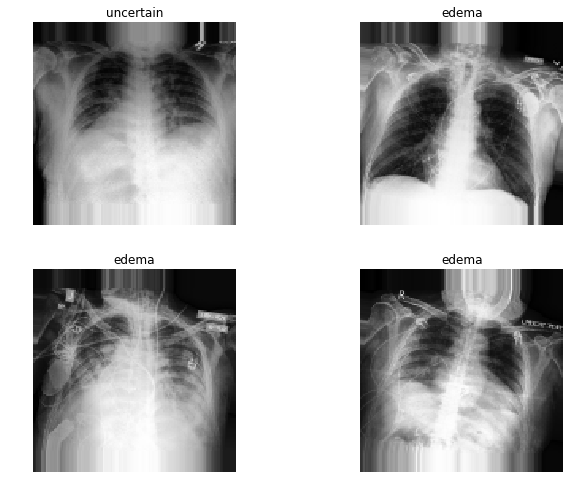

In [94]:
data.show_batch(2, figsize=(10,7))

In [95]:
data.classes

['edema', 'no_edema', 'uncertain']

# Training the RESNET50 Model

In [96]:
arch = models.resnet50

In [97]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


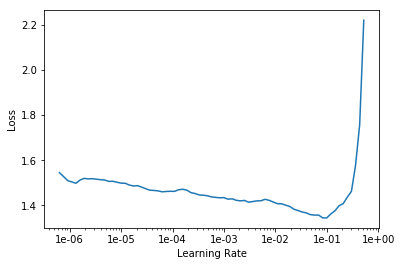

In [16]:
lr_find(learn)
learn.recorder.plot()

In [17]:
lr = 0.001

In [18]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
1,0.813518,0.791589,0.688844,01:44
2,0.759395,0.737612,0.708804,01:45
3,0.725918,0.724326,0.710225,01:45
4,0.723735,0.715577,0.715781,01:45
5,0.714082,0.712572,0.717783,01:46


In [19]:
learn.save('stage-2-rn50')

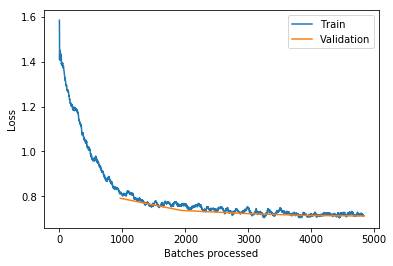

In [20]:
learn.recorder.plot_losses()

In [21]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
1,0.703372,0.713495,0.718494,01:44
2,0.723495,0.712955,0.716814,01:45
3,0.724224,0.710706,0.717137,01:45
4,0.711512,0.705889,0.718558,01:46
5,0.700418,0.702931,0.722692,01:46
6,0.697902,0.701828,0.723274,01:46
7,0.702995,0.697841,0.724501,01:46
8,0.696425,0.697616,0.723920,01:46
9,0.692960,0.696161,0.723661,01:46
10,0.702104,0.696298,0.724501,01:46


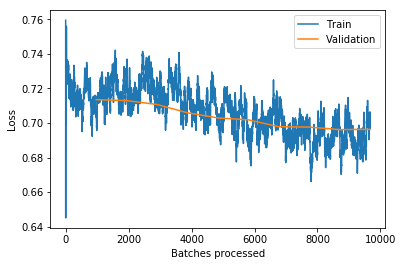

In [22]:
learn.recorder.plot_losses()

In [23]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
1,0.690130,0.696136,0.723855,01:46
2,0.674438,0.697392,0.723467,01:46
3,0.700551,0.696769,0.724889,01:47
4,0.684475,0.695851,0.727925,01:46
5,0.687314,0.694165,0.724953,01:46
6,0.696218,0.691624,0.726956,01:46
7,0.686220,0.694410,0.726503,01:46
8,0.675047,0.691604,0.727408,01:46
9,0.690310,0.691145,0.728441,01:46
10,0.696725,0.692006,0.728441,01:46


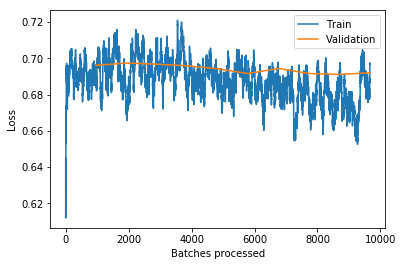

In [24]:
learn.recorder.plot_losses()

In [25]:
#required metrics: Acuracy, training loss, validation loss
learn.unfreeze()

In [26]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
1,0.712369,0.700942,0.723274,02:18
2,0.673791,0.677788,0.729669,02:18


# Saving and loading the model

In [28]:
learn.save('./stage-2-rn50-1')

In [98]:
learn.load('stage-2-rn50-1')

Learner(data=ImageDataBunch;

Train: LabelList (61927 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
uncertain,edema,no_edema,no_edema,edema
Path: .;

Valid: LabelList (15481 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
edema,no_edema,no_edema,edema,uncertain
Path: .;

Test: LabelList (202 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: ., model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1

# Obtaining model predictions

In [99]:
preds, _= learn.get_preds(ds_type=DatasetType.Test)

In [101]:
preds[0]

tensor([0.2457, 0.6758, 0.0785])

In [102]:
learn.data.test_ds.items

array(['./CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg', ...,
       './CheXpert-v1.0-small/valid/patient64737/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64738/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64739/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64740/study1/view1_frontal.jpg'], dtype='<U66')

In [103]:
thresh=0.3
learn.data.c2i

{'edema': 0, 'no_edema': 1, 'uncertain': 2}

In [104]:
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p >= thresh and p==max(pred)]) for pred in preds]
fnames = [f for f in learn.data.test_ds.items]
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
print(df.head(10))

                                          image_name      tags
0  ./CheXpert-v1.0-small/valid/patient64541/study...  no_edema
1  ./CheXpert-v1.0-small/valid/patient64542/study...  no_edema
2  ./CheXpert-v1.0-small/valid/patient64543/study...     edema
3  ./CheXpert-v1.0-small/valid/patient64544/study...  no_edema
4  ./CheXpert-v1.0-small/valid/patient64545/study...     edema
5  ./CheXpert-v1.0-small/valid/patient64546/study...     edema
6  ./CheXpert-v1.0-small/valid/patient64547/study...  no_edema
7  ./CheXpert-v1.0-small/valid/patient64547/study...  no_edema
8  ./CheXpert-v1.0-small/valid/patient64548/study...     edema
9  ./CheXpert-v1.0-small/valid/patient64549/study...  no_edema


In [105]:
df.tags.replace(['uncertain', 'no_edema','edema'],[2,1,0], inplace=True)
y_pred=df.tags

In [106]:
df.tags.unique()

array([1, 0])

In [109]:
y_true=test_df.Edema.replace(['uncertain', 'no_edema','edema'],[2,1,0], inplace=True)

In [110]:
y_pred.unique()

array([1, 0])

In [111]:
y_true=test_df.Edema

In [113]:
y_true.unique()

array([1, 0])

# Calculation of study metrics

In [114]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import recall_score,accuracy_score

              precision    recall  f1-score   support

           0       0.37      0.95      0.53        42
           1       0.98      0.57      0.72       160

    accuracy                           0.65       202
   macro avg       0.67      0.76      0.63       202
weighted avg       0.85      0.65      0.68       202



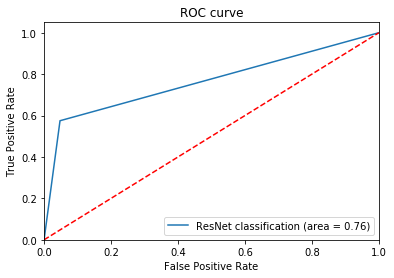

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
print(classification_report(y_true, y_pred))
Roc_auc = roc_auc_score(y_true, y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, label='ResNet classification (area = %0.2f)' % Roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve')
plt.show()